# Q-Learning Basics

TO-DO explain about basics of q learning, giving equations and posing it as a value iteration method. Also talk about the environment (open-ai gym, frozen lake)

## 1. Q-Table Algorithm

Talk about the formulation of problem

In [ ]:
# Imports
import gym
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

#### Load the environment

In [ ]:
env = gym.make('FrozenLake-v0')

In [ ]:
#Initialize table with all zeros
Q = np.zeros([env.observation_space.n,env.action_space.n])
# Set learning parameters
lr = .8
gamma = .95
num_episodes = 2000
#create lists to contain total rewards and steps per episode
jList = []
rList = []

start_time = time.time()
for i in range(num_episodes):
    #Reset environment and get first new observation
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    #The Q-Table learning algorithm
    while j < 99:
        j+=1
        #Choose an action by greedily (with noise) picking from Q table
        a = np.argmax(Q[s,:] + np.random.randn(1,env.action_space.n)*(1./(i+1)))
        #Get new state and reward from environment
        s1,r,d,_ = env.step(a)
        #Update Q-Table with new knowledge
        Q[s,a] = Q[s,a] + lr*(r + gamma*np.max(Q[s1,:]) - Q[s,a])
        rAll += r
        s = s1
        if d == True:
            break
    jList.append(j)
    rList.append(rAll)
    
print ("Score over time: " +  str(sum(rList)/num_episodes))    
print ("Time taken", time.time() - start_time)

In [ ]:
plt.plot(rList)

In [ ]:
plt.plot(jList)

In [ ]:
print ("Final Q-Table Values")
print (Q)

## 2. Q-Network - Tensorflow

In [1]:
import gym
import numpy as np
import random
import tensorflow as tf
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = gym.make('FrozenLake-v0')

[2017-07-14 03:58:00,989] Making new env: FrozenLake-v0


In [3]:
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

In [4]:
#These lines establish the feed-forward part of the network used to choose actions
inputs1 = tf.placeholder(shape=[1,16],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16,4],0,0.01))
Qout = tf.matmul(inputs1,W)
predict = tf.argmax(Qout,1)

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)


In [5]:
init = tf.global_variables_initializer()

# Set learning parameters
y = .99
e = 0.1
num_episodes = 2000
#create lists to contain total rewards and steps per episode
jList = []
rList = []

start_time = time.time()
with tf.Session(config=config) as sess:
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        #The Q-Network
        while j < 99:
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(16)[s:s+1]})
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
            #Get new state and reward from environment
            s1,r,d,_ = env.step(a[0])
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout,feed_dict={inputs1:np.identity(16)[s1:s1+1]})
            #Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            #Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,W],feed_dict={inputs1:np.identity(16)[s:s+1],nextQ:targetQ})
            rAll += r
            s = s1
            if d == True:
                #Reduce chance of random action as we train the model.
                e = 1./((i/50) + 10)
                break
        jList.append(j)
        rList.append(rAll)

print ("Score over time: " +  str(sum(rList)/num_episodes))
print ("total time taken : ", time.time() - start_time)

Score over time: 0.1055
total time taken :  114.51025557518005


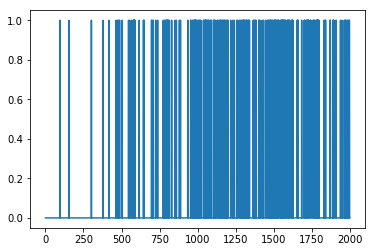

In [6]:
plt.plot(rList)

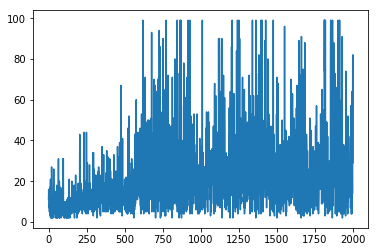

In [7]:
plt.plot(jList)

## 2. Q-Network - PyTorch

In [1]:
import gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = gym.make('FrozenLake-v0')

[2017-07-14 03:52:29,693] Making new env: FrozenLake-v0


In [3]:
# set learning hyper-parameter value
gamma = 0.99
e = 0.1
mu = 0.07
num_episodes = 2000

In [4]:
# Here we will define a feed forward neural network
class Q_Net(nn.Module):
    def __init__(self):
        super(Q_Net, self).__init__()
        self.fc = nn.Linear(16, 4, bias=False)
    
    def forward(self, x):
        return self.fc(x)
        

In [5]:
# Define Network
# W = Variable(torch.normal(0, 0.01), requires_grad=True)
# Define loss
# def criterion(Q, Q_next):
#     return (Q-Q_next).pow(2).sum()

# Initialize the net
Q = Q_Net()
Q_next = Q_Net()

criterion = nn.MSELoss()

# Optimizer setup
optimizer = optim.SGD(Q.parameters(), lr=mu)

In [8]:
# create list to contain total rewards and steps per episode
jList = []
rList = []

# Training the network
start_time = time.time()
for i in range(num_episodes):
    # reset the environment to get first new observation
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    # The Q-Network
    while j < 99:
        j += 1
        # choose an action greedily (with e chance of random action) from the Q-Network
        inp = Variable(torch.eye(16), requires_grad=False)
        # convert model and input to cuda objects if GPU is available
        if torch.cuda.is_available():
            Q.cuda()
            Q_next.cuda()
            inp = inp.cuda()
        
        # reset the gradient matrix of the network
        optimizer.zero_grad()
        # forward pass
        current_Q_value = Q(inp[s:s+1])
        # print (allQ)
        # take the arg max of the output
        _, a = torch.max(current_Q_value.data, 1)

        # choose an action greedily (by e chance of random action) from the Q-Network
        if (np.random.rand(1) < e):
            a[0,0] = env.action_space.sample()

        # Get new state and reward from environment
        s1, r, d, _ = env.step(a[0, 0])
        
        # Obtain the Q' values by feeding the new state through our network
        next_Q_value = Q_next(inp[s1:s1+1]).detach()
        
        # Obtain maxQ' and set our target value for our chosen function
        max_nextQ_value = torch.max(next_Q_value)
        
        targetQ = current_Q_value.data
        targetQ[0, a[0,0]] = r + gamma*max_nextQ_value.data[0]

        # Update the parameters of the network
        targetQ = Variable(targetQ, requires_grad=False)
        
        loss = criterion(current_Q_value, next_Q_value)
        
        loss.backward()
        optimizer.step()
        
        rAll += r
        s = s1
        if (d == True):
            # Reduce the chance of random action as we train the model
            e = 1.0 / ((i/50) + 10)
            break
    jList.append(j)
    rList.append(rAll)

print ("Score over time: " +  str(sum(rList)/num_episodes))
print ("Total time", time.time() - start_time)

Score over time: 0.012
Total time 14.03134822845459


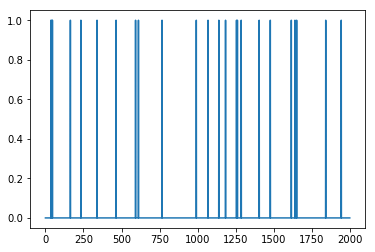

In [9]:
plt.plot(rList)

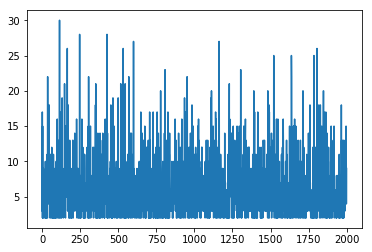

In [10]:
plt.plot(jList)